# Import modules

In [7]:
# !pip install tensorflow==1.15.0 --user
# !pip install -U scikit-learn
# !pip install tensorflow==1.15.5
# !pip3 uninstall https://storage.googleapis.com/tensorflow/mac/cpu/tensorflow-1.14.0-py3-none-any.whl
# !pip install protobuf==3.20. --user
# !pip install --upgrade pip

In [8]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Version 1.0.0 (some previous versions are used in past commits)
# import tensorflow.compat.v1 as tf
#tf.disable_v2_behavior()
from sklearn import metrics
import random
from random import randint
import time
import os

In [9]:
print(tf.__version__)

1.15.0


# Load Dataset

The dataset is the 2D pose estimation of each style dance (afrobeat, classical, hiphop)

In [10]:
#Print some data 

with open('../dataset/finalData/X_train.txt') as f:
  for i, line in enumerate(f):
    if i < 2:
      print(line)
      print(line[50])
      # print(len(line))

292.1815490722656, 379.946533203125, 0.9460499882698059, 297.94085693359375, 377.06689453125, 0.9179264903068542, 289.3019104003906, 377.06689453125, 0.9363464117050171, 306.5798034667969, 385.7058410644531, 0.9603666067123413, 283.5426025390625, 385.7058410644531, 0.9461781978607178, 318.098388671875, 417.3819580078125, 0.902792751789093, 272.0240173339844, 417.3819580078125, 0.8979045748710632, 329.61700439453125, 457.6970520019531, 0.8250201940536499, 263.38507080078125, 454.8174133300781, 0.9007256031036377, 323.8576965332031, 483.6138916015625, 0.8793278932571411, 254.74612426757812, 489.3731994628906, 0.9100959897041321, 318.098388671875, 483.6138916015625, 0.7959131598472595, 283.5426025390625, 486.4935302734375, 0.8071305155754089, 338.25592041015625, 552.7254638671875, 0.848315954208374, 295.06121826171875, 558.4847412109375, 0.888094425201416, 341.1355895996094, 627.5963134765625, 0.898045003414154, 300.82049560546875, 630.4760131835938, 0.8943094611167908

9
164.672378540039

In [11]:
with open('../dataset/finalDataset/X_train.txt') as f:
  for i, line in enumerate(f):
    if i < 2:  
      numbers = line.split(',')
      print(len(numbers))

51
51


# Data path

In [12]:
# Useful Constants

# Output classes to learn how to classify
LABELS = [    
    "afrobeat",
    "classical",
    "hiphop"
] 
DATASET_PATH = "../dataset/finalData copy/"

X_train_path = DATASET_PATH + "X_train.txt"
X_test_path = DATASET_PATH + "X_test.txt"

y_train_path = DATASET_PATH + "Y_train.txt"
y_test_path = DATASET_PATH + "Y_test.txt"

n_steps = 100 # 32 timesteps per series

# Load the network input

In [13]:
# Load the networks inputs

def load_X(X_path):
    file = open(X_path, 'r')
    X_ = np.array(
        [elem for elem in [
            row.split(',') for row in file
        ]], 
        dtype=np.float32
    )
    print("X", X_)
    file.close()
    blocks = int(len(X_) / n_steps)
    print("blocks", blocks)
    X_ = np.array(np.split(X_,blocks))
    print("X", X_)  
    
    return X_ 

# Load the networks outputs

def load_y(y_path):
    file = open(y_path, 'r')
    y_ = np.array(
        [elem for elem in [
            row.replace('  ', ' ').strip().split(' ') for row in file
        ]], 
        dtype=np.int32
    )
    file.close()
    
    # for 0-based indexing 
    return y_ - 1

X_train = load_X(X_train_path)

X_test = load_X(X_test_path)
#print X_test

y_train = load_y(y_train_path)
y_test = load_y(y_test_path)
# proof that it actually works for the skeptical: replace labelled classes with random classes to train on
#for i in range(len(y_train)):
#    y_train[i] = randint(0, 5)

X [[292.18155    379.94653      0.94605    ... 300.8205     630.476
    0.89430946]
 [164.67238    372.5236       0.91066056 ... 127.95229    632.90234
    0.86742735]
 [292.27213    380.3854       0.94750464 ... 300.88342    630.11273
    0.89574   ]
 ...
 [183.6464     145.66808      0.8539027  ... 127.67552    556.1212
    0.7943124 ]
 [205.23262    151.65273      0.9118062  ... 147.11537    442.239
    0.6875173 ]
 [387.73175    247.9892       0.8160939  ... 359.49902    487.9674
    0.63919216]]
blocks 849
X [[[2.9218155e+02 3.7994653e+02 9.4604999e-01 ... 3.0082050e+02
   6.3047601e+02 8.9430946e-01]
  [1.6467238e+02 3.7252359e+02 9.1066056e-01 ... 1.2795229e+02
   6.3290234e+02 8.6742735e-01]
  [2.9227213e+02 3.8038541e+02 9.4750464e-01 ... 3.0088342e+02
   6.3011273e+02 8.9573997e-01]
  ...
  [1.3575566e+02 3.5115054e+02 9.3025529e-01 ... 5.3104065e+01
   6.2885992e+02 8.3033192e-01]
  [2.5638632e+02 3.8962808e+02 9.4590068e-01 ... 2.0220776e+02
   6.3200580e+02 8.0724430e-01]


In [14]:
X_test[43]

array([[1.2676989e+02, 5.5230908e+02, 5.7944212e-02, ..., 1.2374192e+02,
        5.6240234e+02, 2.6035857e-01],
       [1.6508830e+02, 5.4948492e+02, 1.2958640e-01, ..., 1.6166934e+02,
        5.6240106e+02, 3.5576195e-01],
       [1.9373764e+02, 3.1335846e+02, 9.4944257e-01, ..., 2.5120230e+02,
        6.3132965e+02, 6.0596377e-01],
       ...,
       [1.7827586e+02, 2.0335963e+02, 9.2329198e-01, ..., 1.4417892e+02,
        6.4174890e+02, 8.2314640e-01],
       [2.3359465e+02, 5.5028198e+02, 3.3229497e-01, ..., 2.3214360e+02,
        5.6203546e+02, 1.6806658e-01],
       [1.8606282e+02, 2.2380943e+02, 9.4765216e-01, ..., 1.4155562e+02,
        6.2931946e+02, 7.8295380e-01]], dtype=float32)

In [15]:
print("X_train size", len(X_train))
print("X_test size", len(X_test))
print("X_train size", len(y_train))
print("X_test size", len(y_test))

X_train size 849
X_test size 330
X_train size 849
X_test size 330


# Set parameters

In [16]:
# Input data

training_data_count = len(X_train) #1050 training series
test_data_count = len(X_test) #129 test series
n_input = len(X_train[0][0]) #num input parameters per timestep

n_hidden = 60 # Hidden layer num of features
n_classes = 3

#updated for learning rate decay
#calculated as:  decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps)
decaying_learning_rate = True
learning_rate = 0.000000005 #used if decaying_learning_rate set to False
init_learning_rate = 0.0005
decay_rate = 0.96 #the base of the exponential in the decay
decay_steps = 100000 #used in decay every 60000 steps with a base of 0.96

global_step = tf.Variable(0, trainable=False)
lambda_loss_amount = 0.0015

training_iters = training_data_count *200  # Loop 300 times on the dataset, ie 300 epochs
batch_size = 512
display_iter = batch_size*8  # To show test set accuracy during training

print("(X shape, y shape, every X's mean, every X's standard deviation)")
print(X_train.shape, y_test.shape, np.mean(X_test), np.std(X_test))
print("\nThe dataset has not been preprocessed, is not normalised etc")
     


(X shape, y shape, every X's mean, every X's standard deviation)
(849, 100, 51) (330, 1) 269.5301 266.96814

The dataset has not been preprocessed, is not normalised etc


In [17]:
X_test[43]

array([[1.2676989e+02, 5.5230908e+02, 5.7944212e-02, ..., 1.2374192e+02,
        5.6240234e+02, 2.6035857e-01],
       [1.6508830e+02, 5.4948492e+02, 1.2958640e-01, ..., 1.6166934e+02,
        5.6240106e+02, 3.5576195e-01],
       [1.9373764e+02, 3.1335846e+02, 9.4944257e-01, ..., 2.5120230e+02,
        6.3132965e+02, 6.0596377e-01],
       ...,
       [1.7827586e+02, 2.0335963e+02, 9.2329198e-01, ..., 1.4417892e+02,
        6.4174890e+02, 8.2314640e-01],
       [2.3359465e+02, 5.5028198e+02, 3.3229497e-01, ..., 2.3214360e+02,
        5.6203546e+02, 1.6806658e-01],
       [1.8606282e+02, 2.2380943e+02, 9.4765216e-01, ..., 1.4155562e+02,
        6.2931946e+02, 7.8295380e-01]], dtype=float32)

# Utility functions for training

In [18]:
import tensorflow as tf

def LSTM_RNN(_X, _weights, _biases):
    # model architecture based on "guillaume-chevalier" and "aymericdamien" under the MIT license.

    _X = tf.transpose(_X, [1, 0, 2])  # permute n_steps and batch_size
    _X = tf.reshape(_X, [-1, n_input])   
    # Rectifies Linear Unit activation function used
    _X = tf.nn.relu(tf.matmul(_X, _weights['hidden']) + _biases['hidden'])
    # Split data because rnn cell needs a list of inputs for the RNN inner loop
    _X = tf.split(_X, n_steps, 0) 

    # Define two stacked LSTM cells (two recurrent layers deep) with tensorflow
    lstm_cell_1 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cell_2 = tf.compat.v1.nn.rnn_cell.BasicLSTMCell(n_hidden, forget_bias=1.0, state_is_tuple=True)
    lstm_cells = tf.compat.v1.nn.rnn_cell.MultiRNNCell([lstm_cell_1, lstm_cell_2], state_is_tuple=True)
    outputs, states = tf.compat.v1.nn.static_rnn(lstm_cells, _X, dtype=tf.float32)

    # A single output is produced, in style of "many to one" classifier, refer to http://karpathy.github.io/2015/05/21/rnn-effectiveness/ for details
    lstm_last_output = outputs[-1]
    
    # Linear activation
    return tf.matmul(lstm_last_output, _weights['out']) + _biases['out']


def extract_batch_size(_train, _labels, _unsampled, batch_size):
    # Fetch a "batch_size" amount of data and labels from "(X|y)_train" data. 
    # Elements of each batch are chosen randomly, without replacement, from X_train with corresponding label from Y_train
    # unsampled_indices keeps track of sampled data ensuring non-replacement. Resets when remaining datapoints < batch_size    
    
    shape = list(_train.shape)
    shape[0] = batch_size
    batch_s = np.empty(shape)
    batch_labels = np.empty((batch_size,1)) 

    for i in range(batch_size):
        # Loop index
        # index = random sample from _unsampled (indices)
        index = random.choice(_unsampled)
        batch_s[i] = _train[index] 
        batch_labels[i] = _labels[index]
        _unsampled.remove(index)


    return batch_s, batch_labels, _unsampled


def one_hot(y_):
    # One hot encoding of the network outputs
    # e.g.: [[5], [0], [3]] --> [[0, 0, 0, 0, 0, 1], [1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
    
    y_ = y_.reshape(len(y_))
    n_values = int(np.max(y_)) + 1
    return np.eye(n_values)[np.array(y_, dtype=np.int32)]  # Returns FLOATS


# Build the network

In [19]:
# import tensorflow.compat.v1 as tf
# # tf.disable_v2_behavior()
# # tf.compat.v1.disable_v2_behavior()
# tf.compat.v1.disable_eager_execution()

In [20]:
# Graph input/output
x = tf.placeholder(tf.float32, [None, n_steps, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])

# Graph weights
weights = {
    'hidden': tf.Variable(tf.random.normal([n_input, n_hidden])), # Hidden layer weights
    'out': tf.Variable(tf.random.normal([n_hidden, n_classes], mean=1.0))
}
biases = {
    'hidden': tf.Variable(tf.random.normal([n_hidden])),
    'out': tf.Variable(tf.random.normal([n_classes]))
}

pred = LSTM_RNN(x, weights, biases)

# Loss, optimizer and evaluation
l2 = lambda_loss_amount * sum(
    tf.nn.l2_loss(tf_var) for tf_var in tf.compat.v1.trainable_variables()
) # L2 loss prevents this overkill neural network to overfit the data
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y, logits=pred)) + l2 # Softmax loss
if decaying_learning_rate:
    tf.compat.v1.disable_eager_execution()
    learning_rate = tf.compat.v1.train.exponential_decay(init_learning_rate, global_step*batch_size, decay_steps, decay_rate, staircase=True)


#decayed_learning_rate = learning_rate * decay_rate ^ (global_step / decay_steps) #exponentially decayed learning rate
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost,global_step=global_step) # Adam Optimizer

correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


KeyboardInterrupt: 

In [ ]:
saver = tf.train.Saver()

ValueError: No variables to save

In [ ]:
test_losses = []
test_accuracies = []
train_losses = []
train_accuracies = []
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))
init = tf.global_variables_initializer()
sess.run(init)

# Perform Training steps with "batch_size" amount of data at each loop. 
# Elements of each batch are chosen randomly, without replacement, from X_train, 
# restarting when remaining datapoints < batch_size
step = 1
time_start = time.time()
unsampled_indices = list(range(0,len(X_train)))

while step * batch_size <= training_iters:
    #print (sess.run(learning_rate)) #decaying learning rate
    #print (sess.run(global_step)) # global number of iterations
    if len(unsampled_indices) < batch_size:
        unsampled_indices = list(range(0,len(X_train))) 
    batch_xs, raw_labels, unsampled_indicies = extract_batch_size(X_train, y_train, unsampled_indices, batch_size)
    batch_ys = one_hot(raw_labels)
    # check that encoded output is same length as num_classes, if not, pad it 
    if len(batch_ys[0]) < n_classes:
        temp_ys = np.zeros((batch_size, n_classes))
        temp_ys[:batch_ys.shape[0],:batch_ys.shape[1]] = batch_ys
        batch_ys = temp_ys
       
    

    # Fit training using batch data
    _, loss, acc = sess.run(
        [optimizer, cost, accuracy],
        feed_dict={
            x: batch_xs, 
            y: batch_ys
        }
    )
    train_losses.append(loss)
    train_accuracies.append(acc)
    
    # Evaluate network only at some steps for faster training: 
    if (step*batch_size % display_iter == 0) or (step == 1) or (step * batch_size > training_iters):
        
        # To not spam console, show training accuracy/loss in this "if"
        print("Iter #" + str(step*batch_size) + \
              ":  Learning rate = " + "{:.6f}".format(sess.run(learning_rate)) + \
              ":   Batch Loss = " + "{:.6f}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
        # Evaluation on the test set (no learning made here - just evaluation for diagnosis)
        loss, acc = sess.run(
            [cost, accuracy], 
            feed_dict={
                x: X_test,
                y: one_hot(y_test)
            }
        )
        test_losses.append(loss)
        test_accuracies.append(acc)
        print("PERFORMANCE ON TEST SET:             " + \
              "Batch Loss = {}".format(loss) + \
              ", Accuracy = {}".format(acc))
        
          

    step += 1

print("Optimization Finished!")

# Accuracy for test data

one_hot_predictions, accuracy, final_loss = sess.run(
    [pred, accuracy, cost],
    feed_dict={
        x: X_test,
        y: one_hot(y_test)
    }
)

test_losses.append(final_loss)
test_accuracies.append(accuracy)

print("FINAL RESULT: " + \
      "Batch Loss = {}".format(final_loss) + \
      ", Accuracy = {}".format(accuracy))
time_stop = time.time()
print("TOTAL TIME:  {}".format(time_stop - time_start))
     

Device mapping:



Iter #512:  Learning rate = 0.000500:   Batch Loss = 4.907311, Accuracy = 0.3359375
PERFORMANCE ON TEST SET:             Batch Loss = 4.48500394821167, Accuracy = 0.3393939435482025
Iter #4096:  Learning rate = 0.000500:   Batch Loss = 3.543704, Accuracy = 0.69140625
PERFORMANCE ON TEST SET:             Batch Loss = 3.6725025177001953, Accuracy = 0.5878787636756897
Iter #8192:  Learning rate = 0.000500:   Batch Loss = 3.349201, Accuracy = 0.771484375
PERFORMANCE ON TEST SET:             Batch Loss = 3.600578784942627, Accuracy = 0.699999988079071
Iter #12288:  Learning rate = 0.000500:   Batch Loss = 3.284815, Accuracy = 0.76953125
PERFORMANCE ON TEST SET:             Batch Loss = 3.510509967803955, Accuracy = 0.7151514887809753
Iter #16384:  Learning rate = 0.000500:   Batch Loss = 3.189217, Accuracy = 0.80078125
PERFORMANCE ON TEST SET:             Batch Loss = 3.4292373657226562, Accuracy = 0.7272727489471436
Iter #20480:  Learning rate = 0.000500:   Batch Loss = 3.140918, Accuracy 

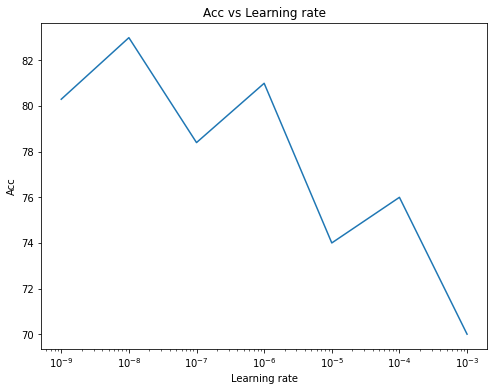

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import ticker

result = [(1e-9, 80.3, 18.6), (1e-8, 83, 15), (1e-7, 78.4, 0.86), (1e-6, 81, 17.08), (1e-5, 74, 13.70), (1e-4, 76, 14.36), (1e-3, 70, 15.6)]
x = []
y = []
lr = [x[0] for x in result]
acc = [x[1] for x in result]
loss = [x[2] for x in result]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(lr, acc)

ax.set_xscale('log')

plt.title("Acc vs Learning rate")
plt.xlabel("Learning rate")
plt.ylabel("Acc")

plt.savefig("accuracy.png")


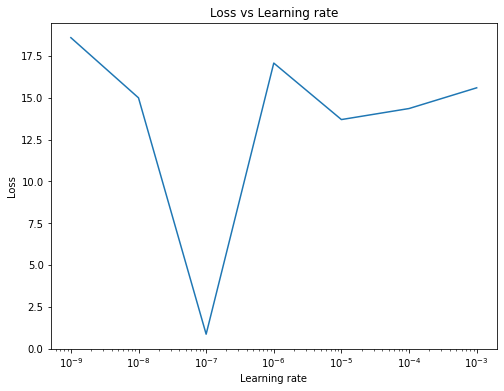

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import ticker

result = [(1e-9, 80.3, 18.6), (1e-8, 83, 15), (1e-7, 78.4, 0.86), (1e-6, 81, 17.08), (1e-5, 74, 13.70), (1e-4, 76, 14.36), (1e-3, 70, 15.6)]
x = []
y = []
lr = [x[0] for x in result]
acc = [x[1] for x in result]
loss = [x[2] for x in result]

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(lr, loss)

ax.set_xscale('log')

plt.title("Loss vs Learning rate")
plt.xlabel("Learning rate")
plt.ylabel("Loss")

plt.savefig("loss.png")


In [ ]:
#save model 
save_path = saver.save(sess, "../models/DanceModel/danceClassify.ckpt", global_step=step)  

findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Bitstream Vera Sans'] not found. Falling back to DejaVu Sans.


43
331


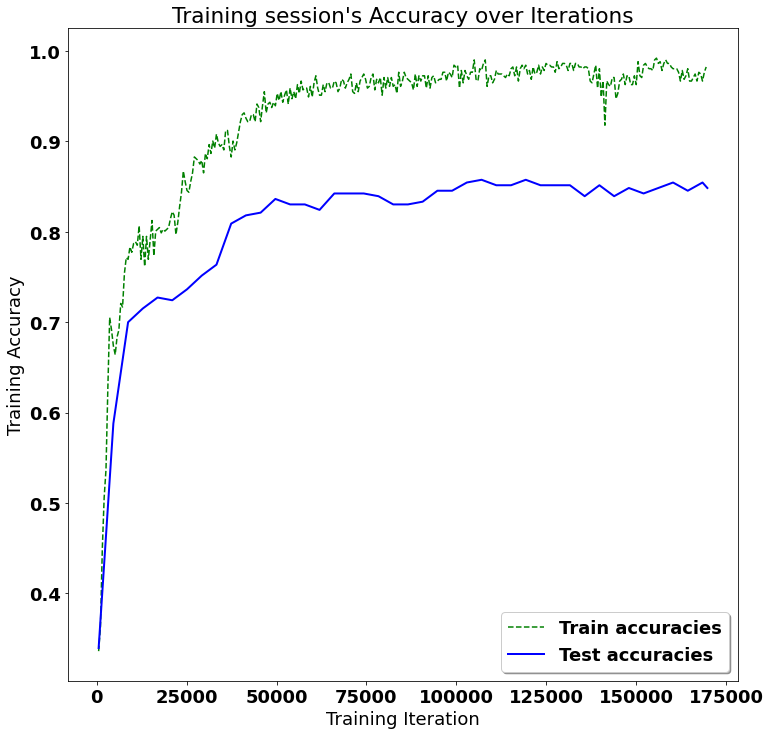

Testing Accuracy: 84.84848737716675%

Precision: 88.14335475525014%
Recall: 84.84848484848484%
f1_score: 84.1137572465006%

Confusion Matrix:
Created using test set of 330 datapoints, normalised to % of each class in the test dataset


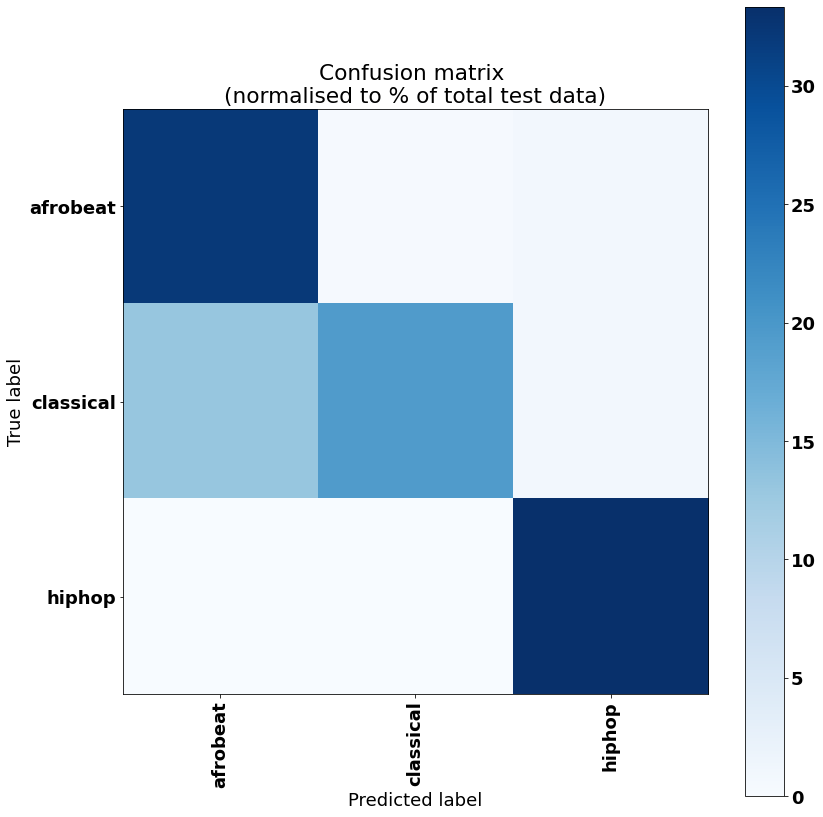

In [ ]:
# (Inline plots: )
%matplotlib inline

font = {
    'family' : 'Bitstream Vera Sans',
    'weight' : 'bold',
    'size'   : 18
}
matplotlib.rc('font', **font)
width = 12
height = 12
plt.figure(figsize=(width, height))

indep_train_axis = np.array(range(batch_size, (len(train_losses)+1)*batch_size, batch_size))
#plt.plot(indep_train_axis, np.array(train_losses),     "b--", label="Train losses")
plt.plot(indep_train_axis, np.array(train_accuracies), "g--", label="Train accuracies")

indep_test_axis = np.append(
    np.array(range(batch_size, len(test_losses)*display_iter, display_iter)[:-1]),
    [training_iters]
)
#plt.plot(indep_test_axis, np.array(test_losses), "b-", linewidth=2.0, label="Test losses")
plt.plot(indep_test_axis, np.array(test_accuracies), "b-", linewidth=2.0, label="Test accuracies")
print(len(test_accuracies))
print(len(train_accuracies))

plt.title("Training session's Accuracy over Iterations")
plt.legend(loc='lower right', shadow=True)
plt.ylabel('Training Accuracy')
plt.xlabel('Training Iteration')

plt.show()

# Results

predictions = one_hot_predictions.argmax(1)

print("Testing Accuracy: {}%".format(100*accuracy))

print("")
print("Precision: {}%".format(100*metrics.precision_score(y_test, predictions, average="weighted")))
print("Recall: {}%".format(100*metrics.recall_score(y_test, predictions, average="weighted")))
print("f1_score: {}%".format(100*metrics.f1_score(y_test, predictions, average="weighted")))

print("")
print("Confusion Matrix:")
print("Created using test set of {} datapoints, normalised to % of each class in the test dataset".format(len(y_test)))
confusion_matrix = metrics.confusion_matrix(y_test, predictions)


#print(confusion_matrix)
normalised_confusion_matrix = np.array(confusion_matrix, dtype=np.float32)/np.sum(confusion_matrix)*100


# Plot Results: 
width = 12
height = 12
plt.figure(figsize=(width, height))
plt.imshow(
    normalised_confusion_matrix, 
    interpolation='nearest', 
    cmap=plt.cm.Blues
)
plt.title("Confusion matrix \n(normalised to % of total test data)")
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, LABELS, rotation=90)
plt.yticks(tick_marks, LABELS)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
save_path1 = "../Script/DanceModel/danceClassify.ckpt-322"

In [ ]:
init = tf.global_variables_initializer()
sess = tf.InteractiveSession(config=tf.ConfigProto(log_device_placement=True))

sess.run(init)
saver.restore(sess, save_path1)
predictions = sess.run(pred, feed_dict={x: np.expand_dims(X_test[43], axis=0)})
predictions

In [ ]:
import torch.nn.functional as F
max_index = np.argmax(predictions)
# get the index of the max probability
label = LABELS[max_index]
print("Label detected ", label)

Label detected  afrobeat
